# Credit Card Fraud Detection: In-Depth Feature Analysis and Model Development

## Exploratory Data Analysis (EDA) Goals
Before modeling, we need to:
1. **Understand the data structure**: fields such as transaction amount, timestamp, card attributes, merchant category
2. **Uncover hidden patterns**: differences between genuine and fraudulent transactions in amount distribution, temporal patterns, geographic or merchant-based behavior
3. **Assess data quality**: check for missing values, outliers, class imbalance, and noise

EDA lays the groundwork for feature engineering, model training, and evaluation, guiding us to build a more robust fraud detection system.

## 1.1 Imports & Configuration
- This section imports the required Python libraries, sets plot styles and display options to prepare for subsequent analysis and visualization.

In [3]:
# 1.1 Import Libraries & Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.tsa.seasonal import seasonal_decompose

# Set display options and plotting style
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

## 1.2  Load & Merge Data
- Load the transaction table `train_transaction.csv` and identity table `train_identity.csv`,
- Merge them on `TransactionID` to create a single dataframe `df`.

In [4]:
#1.2
df_tran = pd.read_csv('Data/train_transaction.csv')
df_id   = pd.read_csv('Data/train_identity.csv')
df = pd.merge(df_tran, df_id, on='TransactionID', how='left')
print(f"Transaction table: {df_tran.shape}, Identity table: {df_id.shape}, Merged data: {df.shape}")

Transaction table: (590540, 394), Identity table: (144233, 41), Merged data: (590540, 434)


## 1.3 Initial overview
- Display the first few rows of the dataset to understand the schema,
- Count the `isFraud` labels and compute the overall fraud rate.

In [5]:
# 1.3 Initial Overview
display(df.head())
print(df['isFraud'].value_counts())
print(f"Overall fraud rate: {df['isFraud'].mean():.4f}")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

isFraud
0    569877
1     20663
Name: count, dtype: int64
Overall fraud rate: 0.0350


## 1.4 Missing Values Analysis
- Visualize missing data patterns, compute missing ratios,
- Plan a strategy to drop, impute, or retain features based on missing percentages.


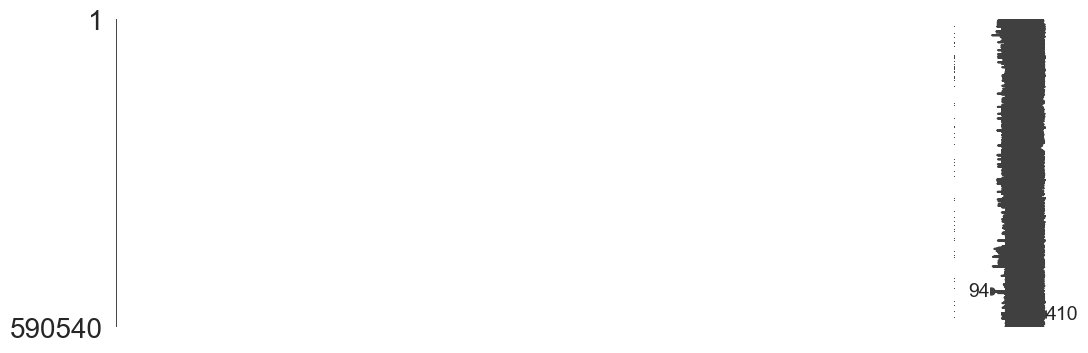

id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
id_03    0.887689
id_04    0.887689
D6       0.876068
id_33    0.875895
id_10    0.873123
dtype: float64

In [6]:
# 1.4 Missing Values Analysis
msno.matrix(df, figsize=(12,4), sparkline=True)
plt.show()

# Compute missing value ratios per column
miss_ratio = df.isnull().mean().sort_values(ascending=False)
display(miss_ratio.head(20))

# Define treatment groups by missing rate
high_miss = miss_ratio[miss_ratio > 0.9].index.tolist()
mid_miss  = miss_ratio[(miss_ratio <= 0.9) & (miss_ratio > 0.1)].index.tolist()
low_miss  = miss_ratio[miss_ratio <= 0.1].index.tolist()

## 1.5 Apply Missing Value Treatment
- Drop features with > 90% missing,
- Impute features with 10%-90% missing using median/mode and add missing indicators.

In [11]:
# 1.5 Apply Missing Value Treatment
df.drop(columns=high_miss, inplace=True, errors='ignore')
for col in mid_miss:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
    if df[col].dtype in ['float64','int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

## 1.6 Timestamp Conversion & Time Features
- Convert `TransactionDT` from seconds since 2017-11-30 to datetime,
- Extract hour, day of week, day, month, and weekend flag.

In [12]:
# 1.6 Timestamp Conversion & Time Features
df['TransactionDT_ts'] = pd.to_datetime(
    df['TransactionDT'], unit='s', origin='2017-11-30'
)
df['Hour']      = df['TransactionDT_ts'].dt.hour
df['DayOfWeek'] = df['TransactionDT_ts'].dt.weekday
df['Day']       = df['TransactionDT_ts'].dt.day
df['Month']     = df['TransactionDT_ts'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)


## 1.7 Numerical Distribution & Log Transform
- Plot histograms for original and log-transformed `TransactionAmt` to visualize skewness.

/var/folders/nd/1hglgj_s3715_14_c4_0gcvc0000gn/T/ipykernel_10250/2620658815.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])


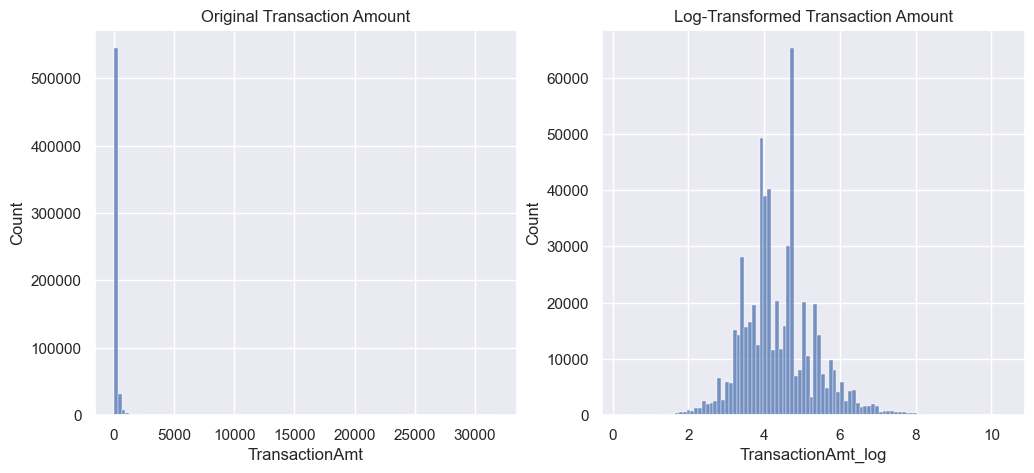

In [9]:
# 1.7 Numerical Distribution & Log Transform
df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['TransactionAmt'], bins=100)
plt.title('Original Transaction Amount')
plt.subplot(1,2,2)
sns.histplot(df['TransactionAmt_log'], bins=100)
plt.title('Log-Transformed Transaction Amount')
plt.show()

## 1.8 Categorical Feature Analysis & Encoding
- Group rare categories, visualize top categories,
- Compute and encode historical fraud rate per category.

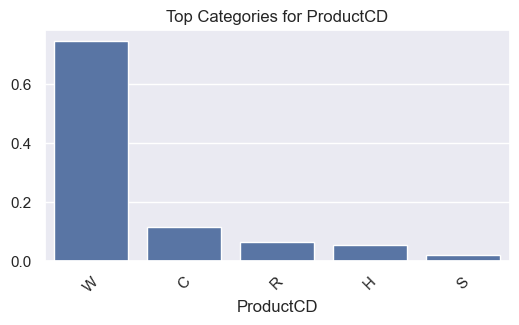

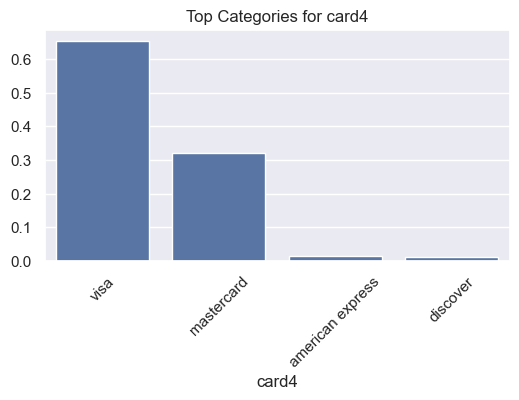

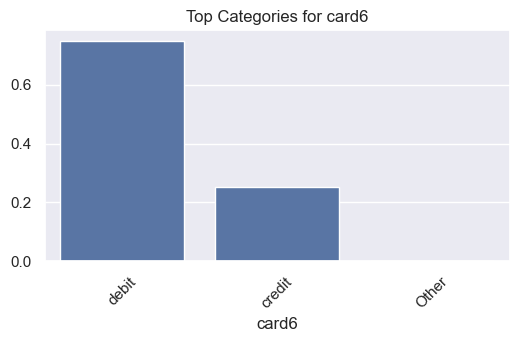

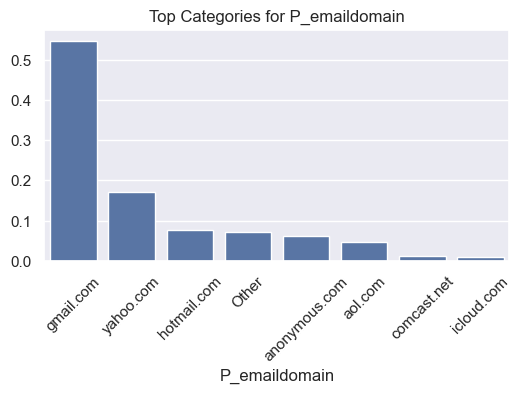

/var/folders/nd/1hglgj_s3715_14_c4_0gcvc0000gn/T/ipykernel_10250/612347849.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_fraud_rate'] = df[col].map(fraud_rate_map)
/var/folders/nd/1hglgj_s3715_14_c4_0gcvc0000gn/T/ipykernel_10250/612347849.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_fraud_rate'] = df[col].map(fraud_rate_map)
/var/folders/nd/1hglgj_s3715_14_c4_0gcvc0000gn/T/ipykernel_10250/612347849.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

In [14]:
# 1.8 Categorical Feature Analysis & Encoding
# Define candidate categorical features and filter existing ones
raw_cat_feats = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'deviceType']
cat_feats = [col for col in raw_cat_feats if col in df.columns]

# Replace rare categories and plot top categories
for col in cat_feats:
    freq = df[col].value_counts(normalize=True)
    rare_cats = freq[freq < 0.01].index
    df[col] = df[col].replace(rare_cats, 'Other')
    plt.figure(figsize=(6,3))
    sns.barplot(x=freq.index[:10], y=freq.values[:10])
    plt.xticks(rotation=45)
    plt.title(f'Top Categories for {col}')
    plt.show()

# Encode historical fraud rate per category
for col in cat_feats:
    fraud_rate_map = df.groupby(col)['isFraud'].mean().to_dict()
    df[f'{col}_fraud_rate'] = df[col].map(fraud_rate_map)

## 1.9 Correlation
- Compute correlation matrix heatmap for select numerical features,
- Perform PCA on high-dimensional V-features to extract top 5 components.

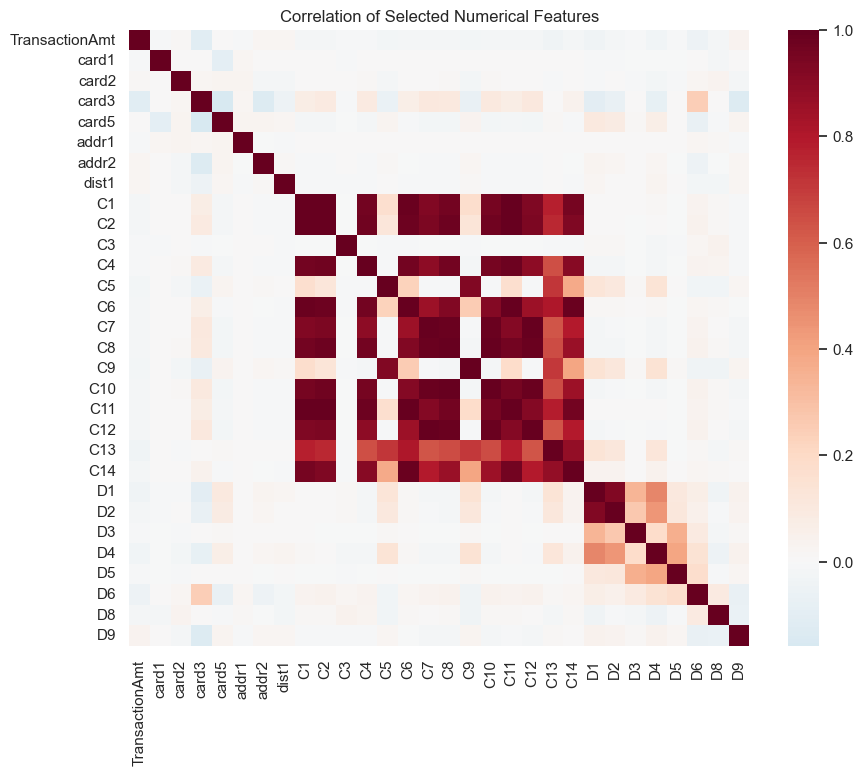

Explained variance ratios: [0.18016223 0.10381741 0.05889346 0.04085472 0.03312956]


In [15]:
# 1.9 Correlation & PCA
to_corr = [c for c in df.select_dtypes(include=['float64','int64']).columns if c not in ['TransactionID','isFraud','TransactionDT']][:30]
corr = df[to_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='RdBu_r', center=0)
plt.title('Correlation of Selected Numerical Features')
plt.show()

V_feats = [c for c in df.columns if c.startswith('V')]
X_V = df[V_feats].fillna(0)
X_scaled = StandardScaler().fit_transform(X_V)
pca = PCA(n_components=5, random_state=42)
pca_feats = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_feats, columns=[f'PCA_V{i+1}' for i in range(5)])
df = pd.concat([df, pca_df], axis=1)
print('Explained variance ratios:', pca.explained_variance_ratio_)


## 1.10 Rolling Window Features
- Compute 1-hour and 24-hour rolling mean of transaction amounts per card to capture recent behavior.

In [19]:
# 1.10 Rolling Window Features
# Ensure timestamp column exists
if 'TransactionDT_ts' not in df.columns:
    df['TransactionDT_ts'] = pd.to_datetime(
        df['TransactionDT'], unit='s', origin='2017-11-30'
    )
# Set datetime index for rolling operation
df_indexed = df.set_index('TransactionDT_ts')

# Calculate rolling means per card
rolling_24h = df_indexed.groupby('card1')['TransactionAmt'].rolling('24h').mean().reset_index(level=0, drop=True)
rolling_1h  = df_indexed.groupby('card1')['TransactionAmt'].rolling('1h').mean().reset_index(level=0, drop=True)

# Assign rolling values back to DataFrame
df['Amt_roll_24h'] = rolling_24h.values
df['Amt_roll_1h']  = rolling_1h.values

# Clean up index to original DataFrame
if 'TransactionDT_ts' not in df.columns:
    df.reset_index(drop=True, inplace=True)

## 1.11 Anomaly Detection
- Train LOF and IsolationForest models to generate anomaly scores,
- Visualize score distributions and compare fraud vs. non-fraud.

/Users/ssa10566/PycharmProjects/Datamining1/.venv/lib/python3.13/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


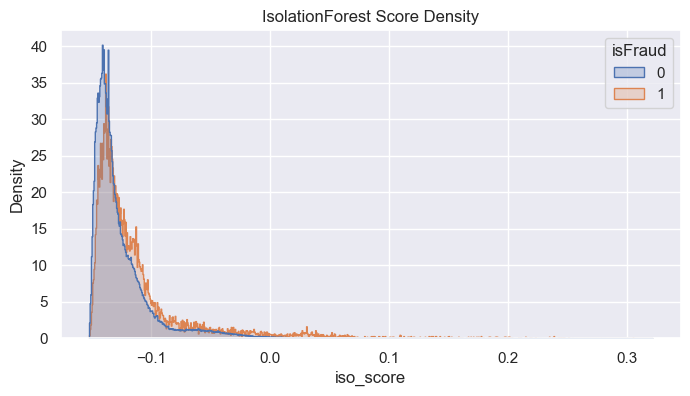

In [20]:
# 1.11 Anomaly Detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df['lof_score'] = -lof.fit_predict(df[to_corr].fillna(0))

iso = IsolationForest(n_estimators=100, max_samples=0.5, contamination=0.01, random_state=42)
df['iso_score'] = -iso.fit(df[to_corr].fillna(0)).decision_function(df[to_corr].fillna(0))

plt.figure(figsize=(8,4))
sns.histplot(data=df, x='iso_score', hue='isFraud', stat='density', element='step', common_norm=False)
plt.title('IsolationForest Score Density')
plt.show()

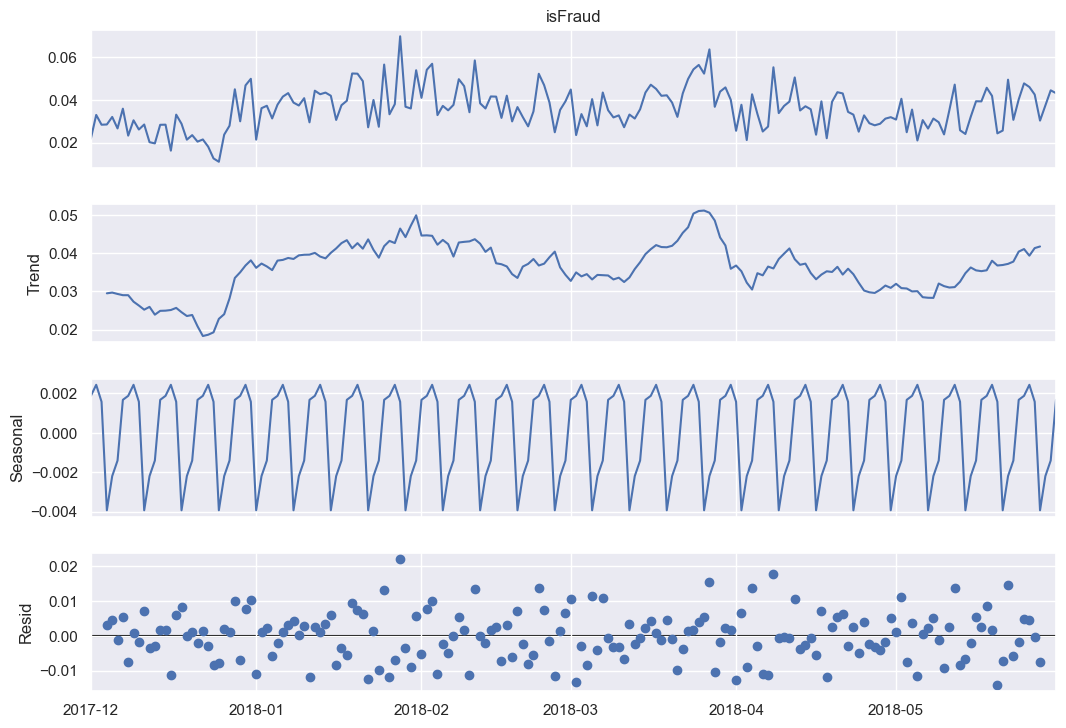

In [21]:
daily = df.set_index('TransactionDT_ts')['isFraud'].resample('D').mean().fillna(0)
decomp = seasonal_decompose(daily, model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.show()

ProductCD chi-square p-value: 0.000e+00


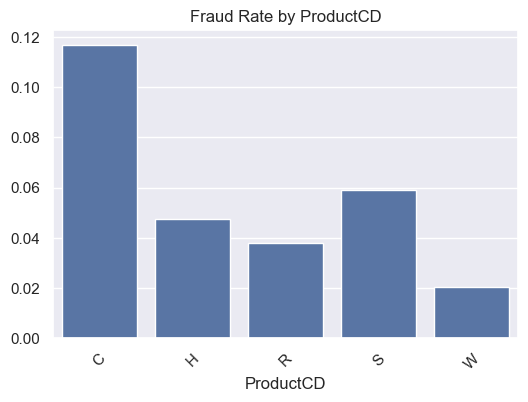

card4 chi-square p-value: 8.970e-79


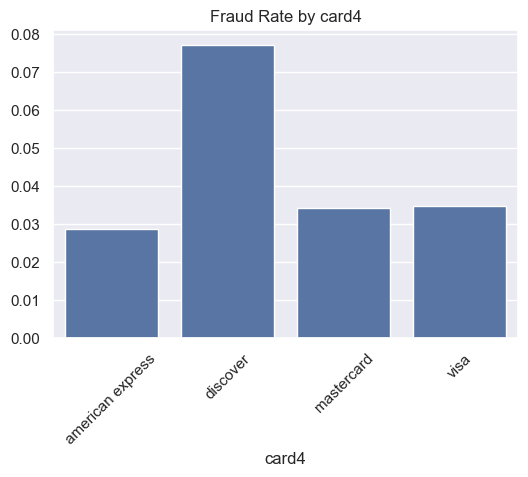

card6 chi-square p-value: 0.000e+00


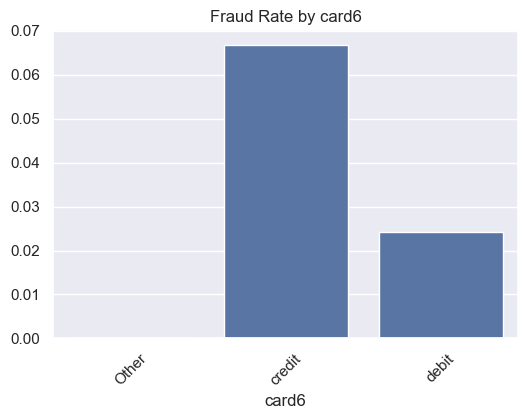

P_emaildomain chi-square p-value: 7.979e-296


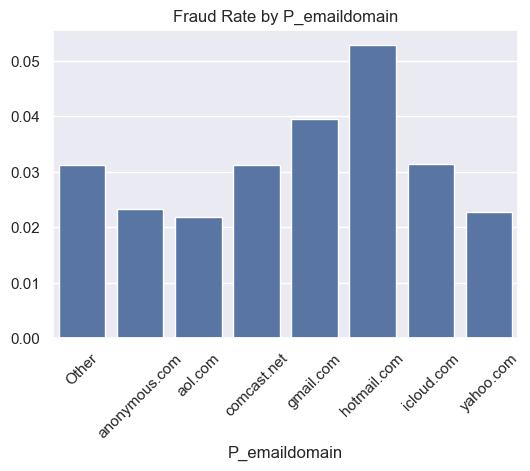

In [22]:
for col in cat_feats:
    ct = pd.crosstab(df[col], df['isFraud'])
    chi2, p, _, _ = chi2_contingency(ct)
    print(f"{col} chi-square p-value: {p:.3e}")
    rate = ct.div(ct.sum(axis=1), axis=0)[1]
    plt.figure(figsize=(6,4))
    sns.barplot(x=rate.index, y=rate.values)
    plt.xticks(rotation=45)
    plt.title(f'Fraud Rate by {col}')
    plt.show()